In [1]:
import numpy as np
import pandas as pd
from statistics import mean, stdev

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO,TraceGraph_ELBO, MCMC, NUTS, HMC
from pyro.poutine.runtime import effectful

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns
import time 

from scipy import stats
import graphviz
from tqdm import tqdm

import yaml



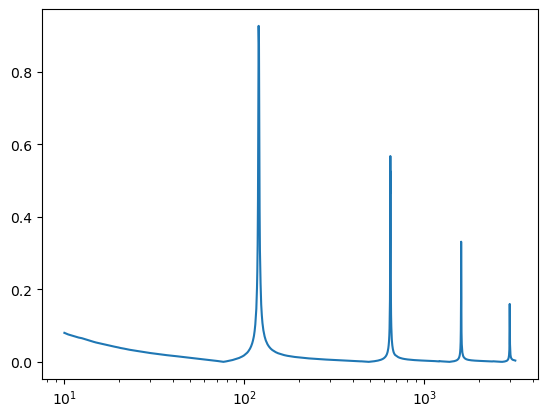

In [2]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
plt.plot(freq, mobility)
plt.xscale("log")

In [6]:
goalFreq

NameError: name 'goalFreq' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3392399647821182
0.12981182607734118


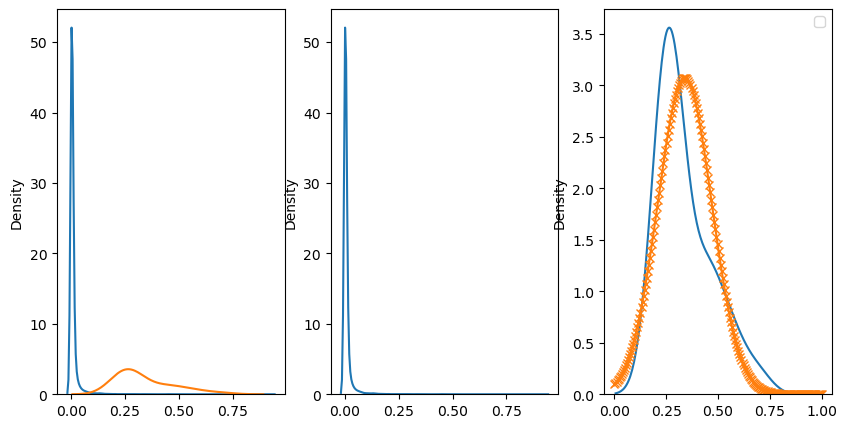

In [3]:
fig, axes = plt.subplots(figsize=(10,5), ncols=3, nrows=1)
goal = mobility[np.logical_and(mobility>0.2, mobility<0.75)]
goalFreq = freq[np.logical_and(mobility>0.2, mobility<0.75)]
#goal = mobility[mobility>0.01]
#goalFreq = freq[mobility>0.01]
sns.kdeplot(mobility, label="mobility all values", ax=axes[0])
sns.kdeplot(goal, label="mobility > 0.2", ax=axes[0])
sns.kdeplot(mobility, ax=axes[1])
meanDist = mean(goal)
stdDist = stdev(goal)
print(meanDist)
print(stdDist)
x = np.linspace(0, 1, 200)
sns.kdeplot(goal, ax=axes[2])
axes[2].plot(x, stats.norm.pdf(x, meanDist, stdDist), "x-")
plt.legend()

In [33]:
stats.beta.fit(goal)

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(0.5989102454863557,
 1.4786801028827505,
 0.2003440295683652,
 0.5116303893151558)

Text(1000, 0.65, 'number of points: 32')

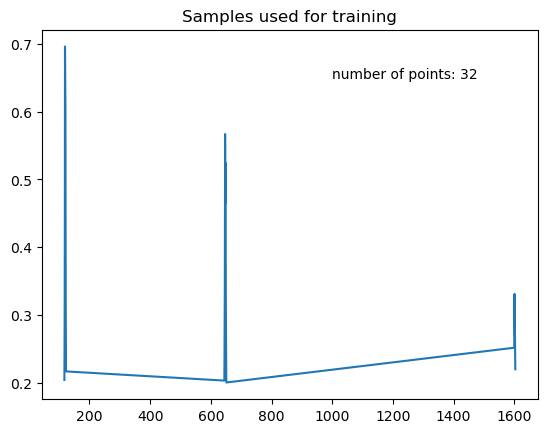

In [4]:
plt.plot(goalFreq, goal)
plt.title("Samples used for training")
plt.text(1000, 0.65,"number of points: "+str(len(goal)))

In [41]:
E_values = []
rho_values = []
eta_values = []
posteriorValues = []
def normalization(rho, eta, E):
    E_theo=torch.tensor(9.7e10)
    E_var_init =torch.tensor(5.0e9)
    rho_theo=torch.tensor(8000.0)
    rho_var_init =torch.tensor(250.0)
    eta_mean=torch.tensor(0.00505)
    eta_var_init =torch.tensor( 0.006)
    
    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_mean
    E_norm = E*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm

def model(x, y_obs):
    """
    # Density definition
    rho_mean = pyro.param("rho_mean", torch.tensor(0.))
    rho_std = pyro.param("rho_std", torch.tensor(1.), constraint=constraints.positive)
    rho = pyro.sample("rho", dist.Normal(rho_mean, rho_std))
    # Damping loss factor definition
    eta_mean = pyro.param("eta_mean", torch.tensor(0.))
    eta_std = pyro.param("eta_std", torch.tensor(1.), constraint=constraints.positive)
    eta = pyro.sample("eta", dist.Normal(eta_mean, eta_std))
    """
    # Young's modulus definition
    E_mean = pyro.param("E_mean", torch.tensor(0.))
    E_std = pyro.param("E_std", torch.tensor(1.), constraint=constraints.positive)
    E = pyro.sample("E", dist.Normal(E_mean, E_std))
    a = pyro.sample("a", torch.tensor(1.))
    rho, eta, E = normalization(rho, eta, E)
    #rho, eta, E = normalization(rho*rho_std+rho_mean, eta*eta_std+eta_mean, E*E_std+E_mean)
    E_values.append(E)
    rho_values.append(rho)
    eta_values.append(eta)
    comsol = torch.tensor(mobilityFuncModelNumpy(E.clone().detach(), 8200, 0.005, x.clone().detach()), requires_grad=False).clone().detach()

    b = (comsol-y_obs)-(a*E)
    #comsol = mobilityFuncModel(E, rho, eta, x)
    #intern = comsol2 - y_values
    #y_values = y_values + intern
    #error = (comsol - y_obs)**2
    #print(E, rho, eta)
    with pyro.plate("data", len(y_obs)):
        y = pyro.sample("y", dist.Normal(comsol, 0.001), obs=torch.zeros(len(y_obs)))
        #y = pyro.sample("y", dist.Beta(paramsBeta[0], paramsBeta[1]), obs=y_obs)
    
    posteriorValues.append(comsol)
    return y

def guide(x, y_obs):
    # Density guide
    rho_mean_q = pyro.param("rho_mean_guide", torch.tensor(0.))
    rho_std_q = pyro.param("rho_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("rho", dist.Normal(rho_mean_q, rho_std_q))
    # Damping loss factor guide
    eta_mean_q = pyro.param("eta_mean_guide", torch.tensor(0.))
    eta_std_q = pyro.param("eta_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("eta", dist.Normal(eta_mean_q, eta_std_q))

    # Damping loss factor guide
    E_mean_q = pyro.param("E_mean_guide", torch.tensor(0.))
    E_std_q = pyro.param("E_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("E", dist.Normal(E_mean_q, E_std_q))

def mobilityFuncModel(E_dist, rho_dist, eta_dist, freq):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*torch.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = torch.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = torch.cos(complex_kl)*torch.cosh(complex_kl) + 1
    D_l = torch.cos(complex_kl)*torch.sinh(complex_kl) + torch.sin(complex_kl)*torch.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*torch.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

def mobilityFuncModelNumpy(E_dist, rho_dist, eta_dist, freq):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12
    
    E = E_dist.clone().detach().numpy()
    rho = rho_dist.clone().detach().numpy()
    eta = eta_dist.clone().detach().numpy()

    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*freq.clone().detach().numpy() # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l

    return abs(Y)

In [42]:
freqTrain = torch.tensor(goalFreq)
data = torch.tensor(goal)

pyro.set_rng_seed(101)
pyro.clear_param_store()
adam_params = {
    "lr": .001, #0.001,
    "betas": (0.96, 0.999),
    "clip_norm": 20.0,
    "lrd": 0.99996,
    "weight_decay": 2.0}
optim = pyro.optim.ClippedAdam(adam_params)
svi = SVI(model, guide, optim, loss=Trace_ELBO())

n_steps = 1000
losses = np.zeros(n_steps)
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 0.01}, 'gamma': 0.1})
for epoch in 10:
    for step in tqdm(range(n_steps)):   
        loss = svi.step(freqTrain, data)
        #print(loss)
        #print("**********************")
        losses[step] = (loss)
    scheduler.step()

100%|██████████| 1000/1000 [00:01<00:00, 598.13it/s]


(-1.0, 1.0)

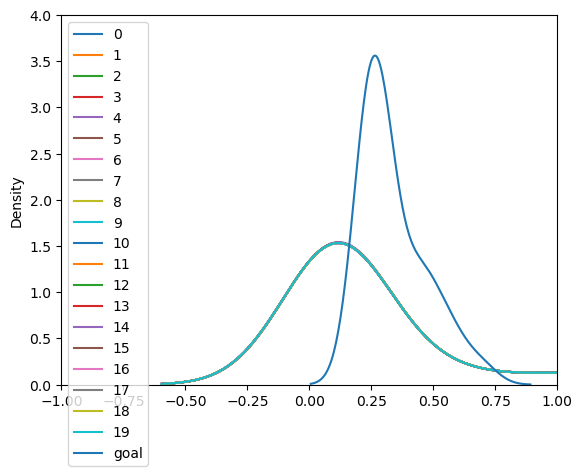

In [43]:
i = 0
for values in posteriorValues[::50]:
    sns.kdeplot(values.detach().numpy(), label=i)
    i += 1
sns.kdeplot(data,label="goal",warn_singular=False)
plt.legend()
plt.ylim([0,4])
plt.xlim([-1,1])

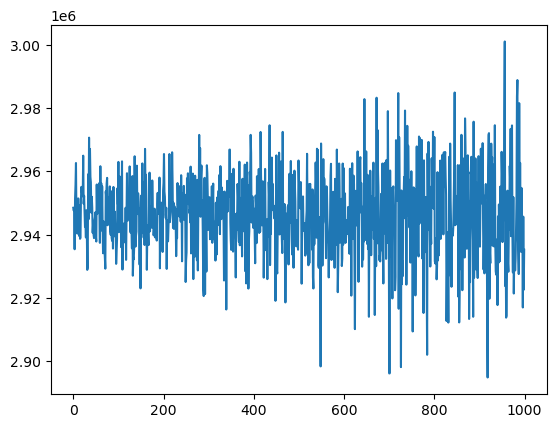

In [44]:
plt.plot(losses)

In [46]:

E_est = pyro.param("E_mean_guide").item()
eta_est = pyro.param("eta_mean_guide").item()
rho_est = pyro.param("rho_mean_guide").item()
E_std = pyro.param("E_std_guide").item()
eta_std = pyro.param("eta_std_guide").item()
rho_std = pyro.param("rho_std_guide").item()       
print(E_est)  
print(E_std)
rho, eta, E = normalization(rho_est, eta_est, E_est)
y_est = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(goalFreq))
y_total = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(freq))
y_init = mobilityFuncModel(torch.tensor(9.7e10), torch.tensor(8000.0), torch.tensor(0.00505), torch.tensor(freq))

print(E)
print(rho)
print(eta)

        

0.0008936158264987171
0.0025950544513761997
tensor(9.7004e+10)
tensor(8000.1431)
tensor(0.0050)


/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_14196/3979703322.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_est = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(goalFreq))
/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_14196/3979703322.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_total = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(freq))


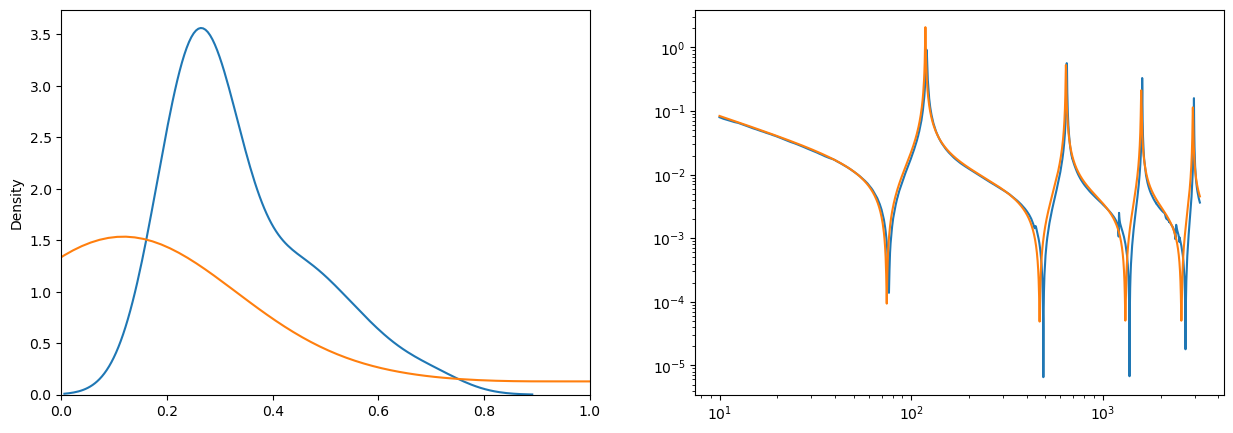

In [47]:
fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
sns.kdeplot(goal, ax=axes[0], label="True posterior")
sns.kdeplot(y_est, ax=axes[0], label="estimated posterior")
axes[0].set_xlim([0,1])
axes[1].plot(freq, mobility)
axes[1].plot(freq, y_total)
axes[1].set_xscale("log")
axes[1].set_yscale("log")

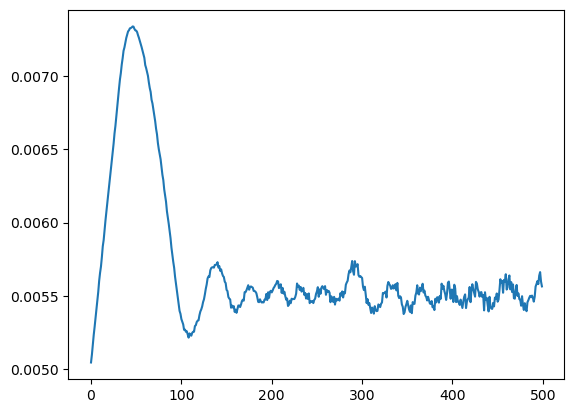

In [55]:
E_val = np.zeros(len(E_values))
eta_val = np.zeros(len(eta_values))
for i in range(len(E_values)):
    E_val[i] = E_values[i].detach().numpy()
    eta_val[i] = eta_values[i].detach().numpy()
plt.plot(eta_val)